# First part

In [16]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import os
import scipy.stats.mstats as ssm
from scipy.stats import gaussian_kde as kde
import random
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import log_loss
from sklearn.metrics import silhouette_score
from sklearn import preprocessing

%matplotlib inline

Time to load the data file

In [2]:
data = pd.read_csv('CrowdstormingDataJuly1st.csv')

and take a look at it:

In [3]:
data.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


To avoid redundancy, we will assume that the reader is familiar with the meaning of each one of the columns of this data set. Based on this, we will drop some rows that are either hard to pass to the random forest, are could not really have information to predict the skin color. The goal is to predict, based on the characteristics of a player, the skin tone.

We have to remember that each row in the dataset represents a dyad between a referee and a player. Now, the dataset was clearly used to check if the referees give more red cards to black players than to white players. In our case we have to check if with the available data (number of Goals, Defeats, red cards, yellow cards) we can infer the skin color of a player.

For that purpose we will generate a new dataset with what we think are important characteristics of the players:

In [42]:
playerNames = data['playerShort'].unique()
mDataFrames = []
for pName in playerNames:
    tmpSet = data[data['playerShort']==pName]
    tmpPlayer = pd.DataFrame(columns=['weight','height','defeats','goals','victories','Color'])
    tmpPlayer['weight']=[tmpSet['weight'].mean()]
    tmpPlayer['height']=[tmpSet['height'].mean()]
    tmpPlayer['victories']=[tmpSet['victories'].sum()]
    tmpPlayer['defeats']=[tmpSet['defeats'].sum()]
    tmpPlayer['goals']=[tmpSet['goals'].sum()]
    tmpPlayer['Color'] = 'Black' if (tmpSet['rater1'].mean()+tmpSet['rater2'].mean())/2>0.5 else 'White'
    
    mDataFrames.append(tmpPlayer)
cleanData = pd.concat(mDataFrames,axis=0, ignore_index=True)
cleanData = cleanData.dropna()

With the generated data sets for training, we will create a random Forest

In [43]:
#Generate a training dataset
features = cleanData.columns[cleanData.columns!=cleanData.columns[-1]]

train = cleanData[features]

labels_str = cleanData['Color']
labels = np.asarray(labels_str, dtype="|S6")

Now we declare our model, and perform a 5-fold cross validation on the full data set:

In [44]:
rfc = RandomForestClassifier(n_estimators=10)
cScore = cross_val_score(rfc,train,labels,cv=5)
cScore

array([ 0.82278481,  0.82278481,  0.85822785,  0.83502538,  0.83502538])

We can simply take the average of this accuracy to obtain an overall accuracy prediction:

In [45]:
cScore.mean()

0.83476964595515002

Let's sheck what is the importance per feature, according to the random forest, when we use all the variables of the original data set.

array([ 0.17466283,  0.16724563,  0.23399936,  0.18708909,  0.23700309])

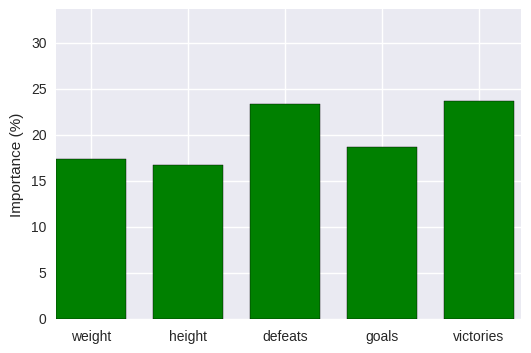

In [46]:
#res = pd.Series(rfc.predict(train)).apply(lambda x: float(x))
rfc.fit(train,labels)
#rfc.score(train,labels)
importances = rfc.feature_importances_
width = 10/len(importances)*0.9
ind = np.linspace(0,10,len(importances))
plt.bar(ind, importances*100, width, color='g')
plt.xticks(ind+width/2, features)
plt.ylabel('Importance (%)')
plt.ylim([0,max(importances*100)+10])
importances

This seems to tell us that the most important feauture for the set are the victories.

# Bonus

It is time to take a look to the learning curves for two different sets of input variables: The script looks long, but is actually fairly simple. First, we generate a set of random indexes to divide easily the data set:

In [47]:
shuffledIndexes = train.iloc[np.random.permutation(len(train))].index

Now, we increasingly build random forests, and evaluate their performance on the full dataset.

In [48]:
vals = 0
results1 = []
results2 = []
disc=20

N = len(train.columns)
while vals < len(shuffledIndexes):
    vals = vals + np.ceil(len(shuffledIndexes)/disc)
    if(vals > np.ceil(len(shuffledIndexes))):
        vals = np.ceil(len(shuffledIndexes))
    vals = int(vals)
    rfc1 = RandomForestClassifier(n_estimators=10)
    rfc2 = RandomForestClassifier(n_estimators=10)
    train_lr=train.loc[shuffledIndexes[0:vals]]
    labels_lr=np.asarray(cleanData.loc[shuffledIndexes[0:vals]]['Color'], dtype="|S6")
    rfc1.fit(train_lr,labels_lr)
    #Test always in the full data set
    results1.append(rfc1.score(train,labels))
    rfc2.fit(train_lr[train_lr.columns[0:N-2]],labels_lr)
    #Test always in the full data set
    results2.append(rfc2.score(train[train.columns[0:N-2]],labels))
percentage = np.linspace(0,100,disc)

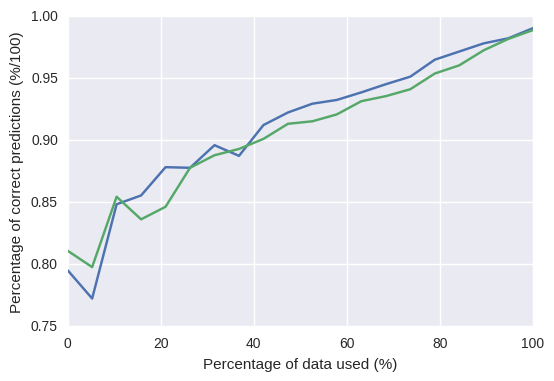

In [49]:
plt.plot(percentage,results1,percentage,results2)
plt.xlabel('Percentage of data used (%)')
plt.ylabel('Percentage of correct predictions (%/100)')
plt.show()

Notice that the percentage of correct predictions at the end of the plot is close to 100%. There is clearly an overfit of the data, which we can see performing a cross validation ( a moderate one with 5 folds ) on the full data set:

# To the second part

Now is time to prepare an unsupervised machine learning method. We will take the safe route and we will try to do it with a KMeans classifier. We will ask the classifier to cluster the data only in two groups:

In [50]:
#myCluster = KMeans(init='random', n_clusters=2, n_init=10)
myCluster = KMeans(n_clusters=2, n_init=10)
myCluster.fit(train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Now, let's receive the prediction of the cluster that the data belongs to. The function will return either 0 or 1 as labels of the data. We turn them into the two labels that the variable label_str contains:

In [51]:
prediction = myCluster.predict(train)
prediction = pd.Series(prediction)
prediction = prediction.apply(lambda x: labels_str.unique()[0] if x==1 else labels_str.unique()[1])
prediction.index = labels_str.index

Now, as we could by mistake used the wrong label, we simply check in which entries they agree and in which ones they don't and we take the maximum between that percentage, called acc, and 1-acc which would be the accuracy with the labels switched

In [52]:
acc = (prediction==labels_str).sum()/len(labels_str)

acc = max(acc,1-acc)
acc

0.67105930055752661

Even though it is best way to see the error of the prediction, in the case of only 2 clusters it is feasible to calculate the error like this, and gives us an idea that the possibility of the description of the player being bound to his skin color is low.

Now, we do the same but removing features, and using rather the silhouette_score:

In [20]:
silhouette_score(train,labels_str)

0.0046670318435153334